In [1]:
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Resize, Normalize
from torchvision.io import read_image

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
class ImageDataset(Dataset):
    def __init__(self,img_folder,transform):
        self.transform=transform
        self.img_folder=img_folder

        self.image_names=[i for i in os.listdir(self.img_folder) if '.jpg' in i]
   
    def __len__(self):
        return len(self.image_names)
 
    def __getitem__(self, index):
        image_path = self.img_folder + self.image_names[index]
        image=Image.open(image_path)
        image=self.transform(image)

        return image

In [4]:
img_dim = 32
training_data = ImageDataset(img_folder='sample_data/img/',transform=Compose([
                                               Resize((img_dim, img_dim)),
                                               ToTensor(),
                                               Normalize(0,1),
                                           ]))
batch_size = 32

train_dataloader = DataLoader(training_data, batch_size = batch_size)

In [5]:
for X in train_dataloader:
    print(X.shape)
    break

torch.Size([32, 3, 32, 32])


In [6]:
def weights_init(m):
    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            m.bias.data.fill_(0)

In [7]:
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.z_dim = z_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride = 1,bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope = 0.1),
            
            nn.Conv2d(32, 64, 4, stride = 2,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope = 0.1),
            
            nn.Conv2d(64, 128, 4, stride = 2,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope = 0.1),
            
            nn.Conv2d(128, 256, 4, stride = 1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope = 0.1),
            
            nn.Conv2d(256, 2*z_dim, 2, stride = 1, bias=True)
        )
    def reparameterize(self, z):
        z = z.view(z.size(0), -1)
        mu, log_sigma = z[:, :self.z_dim], z[:, self.z_dim:]
        std = torch.exp(log_sigma)
        eps = torch.randn_like(std)
        return mu + eps*std
        
    def forward(self, x):
        z = self.encoder(x)
        z = self.reparameterize(z)
        return z.view(x.size(0), self.z_dim, 1, 1)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, num_channel = 3):
        super(Discriminator, self).__init__()
        
        self.conv1x = nn.Conv2d(num_channel, 32, 5, stride = 1, bias=False)
        self.conv2x = nn.Conv2d(32, 64, 4, stride = 2, bias=False)
        self.bn1x = nn.BatchNorm2d(64)
        self.conv3x = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.bn2x =  nn.BatchNorm2d(128)
        self.conv4x = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
        self.bn3x = nn.BatchNorm2d(256)
        self.conv5x = nn.Conv2d(256, 512, 4, 2, 1, bias=False)
        self.bn4x = nn.BatchNorm2d(512)
        
        self.conv1z = nn.Conv2d(z_dim, 512, 1, stride = 1, bias=False)
        self.conv2z = nn.Conv2d(512, 512, 1, stride = 1, bias=False)
        
        self.conv1xz = nn.Conv2d(1024, 1024, 1, stride = 1, bias=False)
        self.conv2xz = nn.Conv2d(1024, 1024, 1, stride = 1, bias=False)
        self.conv3xz = nn.Conv2d(1024, 1, 1, stride = 1, bias=False)
       
    def forward(self, x, z):
        x = F.leaky_relu(self.conv1x(x), negative_slope = 0.2)
        x = F.leaky_relu(self.bn1x(self.conv2x(x)), negative_slope = 0.2)
        x = F.leaky_relu(self.bn2x(self.conv3x(x)), negative_slope = 0.2)
        x = F.leaky_relu(self.bn3x(self.conv4x(x)), negative_slope = 0.2)
        x = F.leaky_relu(self.bn4x(self.conv5x(x)), negative_slope = 0.2)
       
        z = F.leaky_relu(self.conv1z(z), negative_slope = 0.2)
        z = F.leaky_relu(self.conv2z(z), negative_slope = 0.2)
    
        xz = torch.cat((x,z), dim = 1)
        
        xz = F.leaky_relu(self.conv1xz(xz), negative_slope = 0.2)
        xz = F.leaky_relu(self.conv2xz(xz), negative_slope = 0.2)
        xz = F.leaky_relu(self.conv3xz(xz), negative_slope = 0.2)
        
        return torch.sigmoid(xz)

In [9]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim, num_channel = 3):
        super(Generator, self).__init__()
        self.output_bias = nn.Parameter(torch.zeros(3,img_dim, img_dim), requires_grad = True)
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 256, 4, stride = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope = 0.1, inplace=True),
            
            nn.ConvTranspose2d(256, 128, 4, stride = 2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope = 0.1, inplace=True),
            
            nn.ConvTranspose2d(128, 64, 4, stride = 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope = 0.1, inplace=True),
            
            nn.ConvTranspose2d(64, 32, 4, stride = 2, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope = 0.1, inplace=True),
            
            nn.ConvTranspose2d(32, 32, 5, stride = 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope = 0.1, inplace=True),
            
            nn.ConvTranspose2d(32, 3, 1, stride = 1, bias=True),
            nn.Sigmoid()
        )
    
    def forward(self, z):
        z = self.main(z)
        out = z + self.output_bias
        return out

In [10]:
z_dim = 100

g = Generator(z_dim, img_dim).to(device)
e = Encoder(z_dim).to(device)
d = Discriminator().to(device)

g.apply(weights_init)
e.apply(weights_init)
d.apply(weights_init)

Discriminator(
  (conv1x): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (conv2x): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
  (bn1x): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3x): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2x): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4x): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3x): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5x): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4x): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1z): Conv2d(100, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (conv2z): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (conv1xz): Conv2d(1024, 1024, kernel_size=(1, 

In [11]:
criterion = nn.BCELoss()

real_label = 1
fake_label = 0

lr = 1e-4
beta1 = 0.5

ge_param = list(g.parameters())+list(e.parameters())

opt_ge = optim.Adam(ge_param, lr = lr,  betas=(beta1, 0.999))
opt_d = optim.Adam(d.parameters(), lr = lr,  betas=(beta1, 0.999))

In [12]:
def plot_img(fake):
    with torch.no_grad():
        fake = np.transpose(fake.cpu().numpy(), (0, 2, 3, 1))

    _,ax = plt.subplots(1, 10, figsize=(24,4))
    for i in range(10):
        ax[i].imshow(fake[i])
    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

[1] D Loss : 0.90538 GE Loss : 4.40849


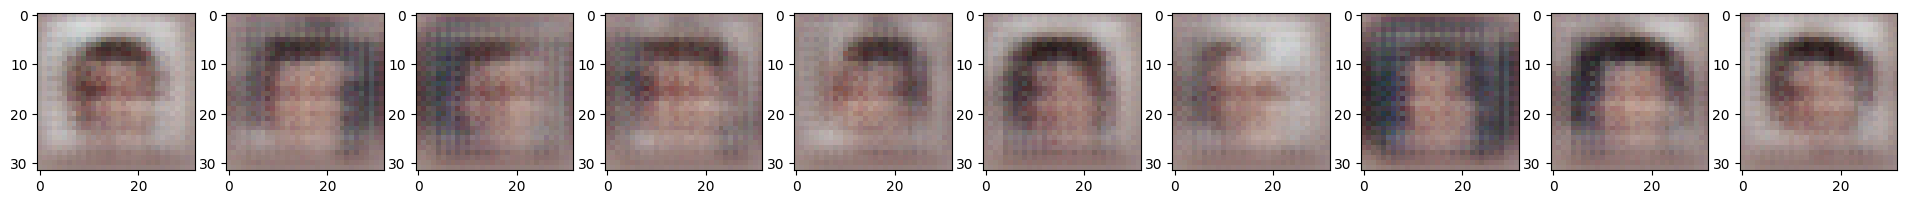

  0%|          | 0/316 [00:00<?, ?it/s]

[2] D Loss : 0.83531 GE Loss : 5.16921


  0%|          | 0/316 [00:00<?, ?it/s]

[3] D Loss : 1.02320 GE Loss : 3.75251


  0%|          | 0/316 [00:00<?, ?it/s]

[4] D Loss : 1.18782 GE Loss : 2.66862


  0%|          | 0/316 [00:00<?, ?it/s]

[5] D Loss : 1.21293 GE Loss : 2.36944


  0%|          | 0/316 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[6] D Loss : 1.17098 GE Loss : 2.59188


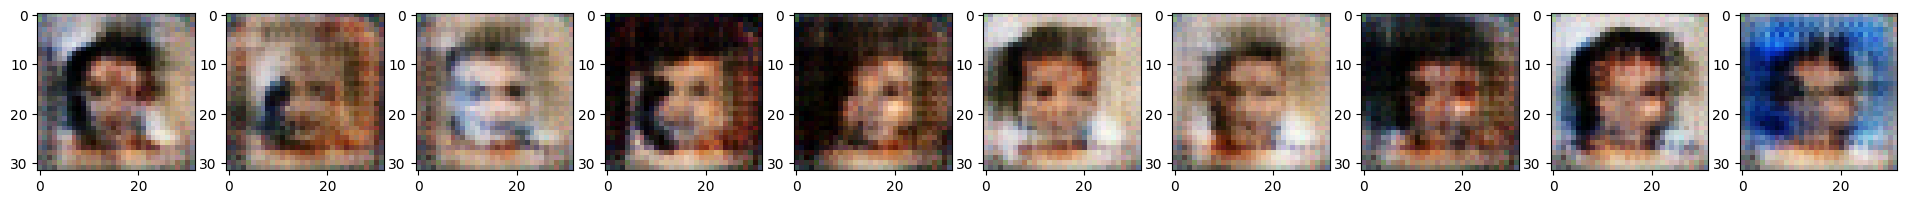

  0%|          | 0/316 [00:00<?, ?it/s]

[7] D Loss : 1.20846 GE Loss : 2.43781


  0%|          | 0/316 [00:00<?, ?it/s]

[8] D Loss : 1.24746 GE Loss : 2.25249


  0%|          | 0/316 [00:00<?, ?it/s]

[9] D Loss : 1.23073 GE Loss : 2.25606


  0%|          | 0/316 [00:00<?, ?it/s]

[10] D Loss : 1.21267 GE Loss : 2.40498


  0%|          | 0/316 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[11] D Loss : 1.20900 GE Loss : 2.41097


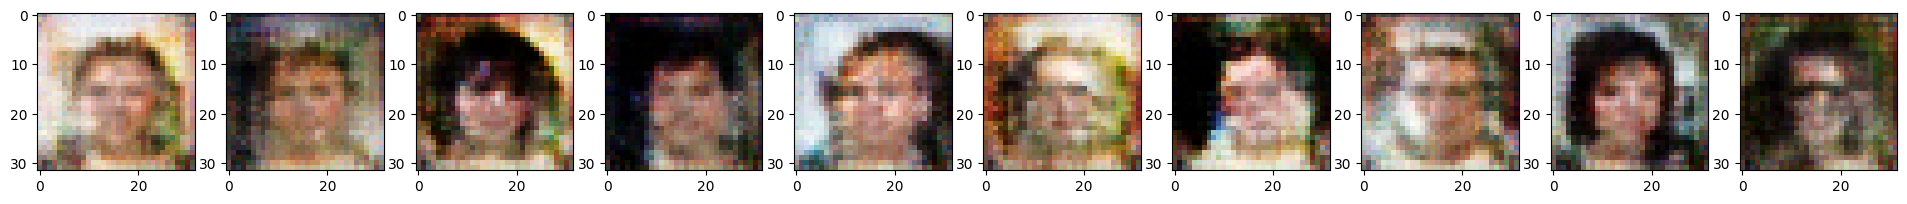

  0%|          | 0/316 [00:00<?, ?it/s]

[12] D Loss : 1.20948 GE Loss : 2.44816


  0%|          | 0/316 [00:00<?, ?it/s]

[13] D Loss : 1.17799 GE Loss : 2.58234


  0%|          | 0/316 [00:00<?, ?it/s]

[14] D Loss : 1.15436 GE Loss : 2.71432


  0%|          | 0/316 [00:00<?, ?it/s]

[15] D Loss : 1.09014 GE Loss : 3.07567


  0%|          | 0/316 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[16] D Loss : 1.05767 GE Loss : 3.31777


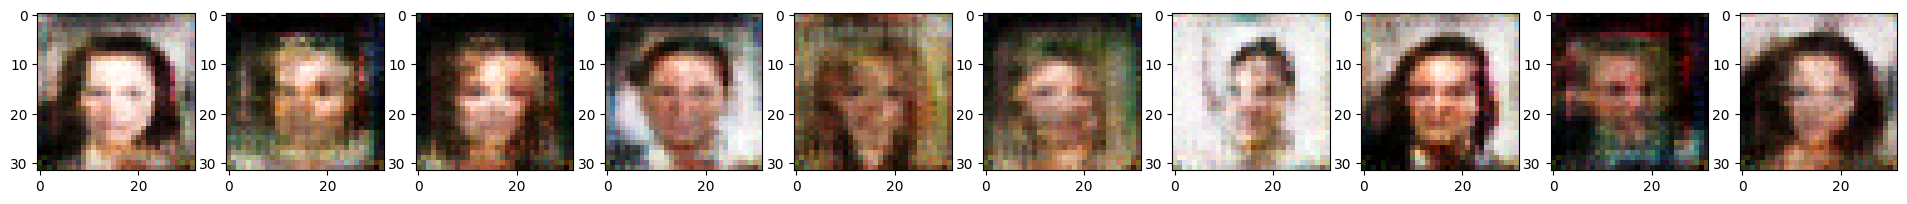

  0%|          | 0/316 [00:00<?, ?it/s]

In [ ]:
epochs = 50
num_steps = len(train_dataloader.dataset)//batch_size

clip_value = 1.2

for epoch in tqdm(range(epochs)):
    ge_loss, d_loss = 0, 0
    for step, (X) in tqdm(enumerate(train_dataloader), total=num_steps):
        X = X.to(device)
        y_true = Variable(torch.ones(X.size(0),1, dtype=torch.float).to(device), requires_grad = False)
        y_fake = Variable(torch.zeros(X.size(0), 1, dtype=torch.float).to(device), requires_grad = False)
        
        noise1 = Variable(torch.Tensor(X.size()).normal_(0, 0.1 * (epochs - epoch) / epochs),requires_grad=False).to(device)
        noise2 = Variable(torch.Tensor(X.size()).normal_(0, 0.1 * (epochs - epoch) / epochs),requires_grad=False).to(device)
   
        ######## TRAINING DISCRIMINATOR ###########
        opt_d.zero_grad()

        z_fake = Variable(torch.randn((X.size(0), z_dim, 1, 1)).to(device), requires_grad = False)
        x_fake = g(z_fake)

        z_true = e(X)

        out_true = d(X+noise1, z_true).view(X.shape[0],-1)
        out_fake = d(x_fake+noise2, z_fake).view(X.shape[0],-1)

        loss_d = criterion(out_true, y_true) + criterion(out_fake, y_fake)
        loss_d.backward()
        nn.utils.clip_grad_value_(d.parameters(), clip_value)
        opt_d.step()
            
        ######## TRAINING GENERATOR AND ENCODER PART ###########
            
        opt_ge.zero_grad()
            
        z_fake = Variable(torch.randn((X.size(0), z_dim, 1, 1)).to(device), requires_grad = False)
        x_fake = g(z_fake)

        z_true = e(X)

        out_true = d(X+noise1, z_true).view(X.shape[0],-1)
        out_fake = d(x_fake+noise2, z_fake).view(X.shape[0],-1)
            
        loss_ge = criterion(out_fake, y_true) + criterion(out_true, y_fake)
        loss_ge.backward()
        nn.utils.clip_grad_value_(ge_param, clip_value)
        opt_ge.step()
            
        ge_loss += loss_ge.item()
        d_loss += loss_d.item()
            
    print(f"[{epoch+1}] D Loss : {d_loss/num_steps:>.5f} GE Loss : {ge_loss/num_steps:>.5f}")
    if epoch % 5 == 0:
        z_fake = torch.randn((X.size(0), z_dim, 1, 1)).to(device)
        plot_img(g(z_fake)) 

In [ ]:
z_fake = torch.randn((batch_size, z_dim, 1, 1)).to(device)
plot_img(g(z_fake))